In [1]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.simulate.credentials import create_credentials
from qm.simulate import SimulationConfig
from qm.qua import *


# build config
qmm = QuantumMachinesManager(host="nord-quantique-d14d58b1.quantum-machines.co", port=443,
                             credentials=create_credentials())

2022-08-05 16:18:56,692 - qm - INFO - Performing health check
2022-08-05 16:18:57,001 - qm - INFO - Health check passed


In [2]:
import numpy as np
from scipy.signal.windows import gaussian
from qualang_tools.config.waveform_tools import drag_gaussian_pulse_waveforms
from qualang_tools.units import unit
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool


# Config

In [3]:
#######################
# AUXILIARY FUNCTIONS #
#######################

# IQ imbalance matrix
def IQ_imbalance(g, phi):
    """
    Creates the correction matrix for the mixer imbalance caused by the gain and phase imbalances, more information can
    be seen here:
    https://docs.qualang.io/libs/examples/mixer-calibration/#non-ideal-mixer
    :param g: relative gain imbalance between the I & Q ports (unit-less). Set to 0 for no gain imbalance.
    :param phi: relative phase imbalance between the I & Q ports (radians). Set to 0 for no phase imbalance.
    """
    c = np.cos(phi)
    s = np.sin(phi)
    N = 1 / ((1 - g**2) * (2 * c**2 - 1))
    return [float(N * x) for x in [(1 - g) * c, (1 + g) * s, (1 - g) * s, (1 + g) * c]]

#############
# VARIABLES #
#############
u = unit()
# qop_ip = "127.0.0.1"

# Qubits
qubit_IF = 50e6
qubit_LO = 7e9
mixer_qubit_g = 0.0
mixer_qubit_phi = 0.0

qubit_T1 = int(10e3)

saturation_len = 1000
saturation_amp = 0.1
const_len = 100
const_amp = 0.1
square_pi_len = 100
square_pi_amp = 0.1

drag_coef = 0
anharmonicity = -200e6

gauss_len = 20
gauss_sigma = gauss_len / 5
gauss_amp = 0.35
gauss_wf = gauss_amp * gaussian(gauss_len, gauss_sigma)

displace_len = 40
displace_sigma = displace_len / 5
displace_amp = 0.35
displace_wf = displace_amp * gaussian(displace_len, displace_sigma)

x180_len = 40
x180_sigma = x180_len / 5
x180_amp = 0.35
x180_wf, x180_der_wf = np.array(
    drag_gaussian_pulse_waveforms(x180_amp, x180_len, x180_sigma, alpha=drag_coef, delta=anharmonicity)
)
x180_I_wf = x180_wf
x180_Q_wf = x180_der_wf
# No DRAG when alpha=0, it's just a gaussian.

x90_len = x180_len
x90_sigma = x90_len / 5
x90_amp = x180_amp / 2
x90_wf, x90_der_wf = np.array(
    drag_gaussian_pulse_waveforms(x90_amp, x90_len, x90_sigma, alpha=drag_coef, delta=anharmonicity)
)
x90_I_wf = x90_wf
x90_Q_wf = x90_der_wf
# No DRAG when alpha=0, it's just a gaussian.

minus_x90_len = x180_len
minus_x90_sigma = minus_x90_len / 5
minus_x90_amp = -x90_amp
minus_x90_wf, minus_x90_der_wf = np.array(
    drag_gaussian_pulse_waveforms(minus_x90_amp, minus_x90_len, minus_x90_sigma, alpha=drag_coef, delta=anharmonicity)
)
minus_x90_I_wf = minus_x90_wf
minus_x90_Q_wf = minus_x90_der_wf
# No DRAG when alpha=0, it's just a gaussian.

y180_len = x180_len
y180_sigma = y180_len / 5
y180_amp = x180_amp
y180_wf, y180_der_wf = np.array(
    drag_gaussian_pulse_waveforms(y180_amp, y180_len, y180_sigma, alpha=drag_coef, delta=anharmonicity)
)
y180_I_wf = (-1) * y180_der_wf
y180_Q_wf = y180_wf
# No DRAG when alpha=0, it's just a gaussian.

y90_len = x180_len
y90_sigma = y90_len / 5
y90_amp = y180_amp / 2
y90_wf, y90_der_wf = np.array(
    drag_gaussian_pulse_waveforms(y90_amp, y90_len, y90_sigma, alpha=drag_coef, delta=anharmonicity)
)
y90_I_wf = (-1) * y90_der_wf
y90_Q_wf = y90_wf
# No DRAG when alpha=0, it's just a gaussian.

minus_y90_len = y180_len
minus_y90_sigma = minus_y90_len / 5
minus_y90_amp = -y90_amp
minus_y90_wf, minus_y90_der_wf = np.array(
    drag_gaussian_pulse_waveforms(minus_y90_amp, minus_y90_len, minus_y90_sigma, alpha=drag_coef, delta=anharmonicity)
)
minus_y90_I_wf = (-1) * minus_y90_der_wf
minus_y90_Q_wf = minus_y90_wf
# No DRAG when alpha=0, it's just a gaussian.

# Resonator
resonator_IF = 60e6
resonator_LO = 5.5e9
mixer_resonator_g = 0.0
mixer_resonator_phi = 0.0

time_of_flight = 180

short_readout_len = 500
short_readout_amp = 0.4
readout_len = 5000
readout_amp = 0.2
long_readout_len = 50000
long_readout_amp = 0.1

# IQ Plane
rotation_angle = (0.0 / 180) * np.pi
ge_threshold = 0.0


config = {
    "version": 1,
    "controllers": {
        "con1": {
            "analog_outputs": {
                1: {"offset": 0.0},  # I qubit
                2: {"offset": 0.0},  # Q qubit
                3: {"offset": 0.0},  # I resonator
                4: {"offset": 0.0},  # Q resonator
            },
            "digital_outputs": {},
            "analog_inputs": {
                1: {"offset": 0.0, "gain_db": 0},  # I from down-conversion
                2: {"offset": 0.0, "gain_db": 0},  # Q from down-conversion
            },
        },
    },
    "elements": {
        "qubit": {
            "mixInputs": {
                "I": ("con1", 1),
                "Q": ("con1", 2),
                "lo_frequency": qubit_LO,
                "mixer": "mixer_qubit",
            },
            "intermediate_frequency": qubit_IF,
            "operations": {
                "cw": "const_pulse",
                "saturation": "saturation_pulse",
                "gauss": "gaussian_pulse",
                "pi": "x180_pulse",
                "pi_half": "x90_pulse",
                "x90": "x90_pulse",
                "x180": "x180_pulse",
                "-x90": "-x90_pulse",
                "y90": "y90_pulse",
                "y180": "y180_pulse",
                "-y90": "-y90_pulse",
            },
        },
        "resonator": {
            "mixInputs": {
                "I": ("con1", 3),
                "Q": ("con1", 4),
                "lo_frequency": resonator_LO,
                "mixer": "mixer_resonator",
            },
            "intermediate_frequency": resonator_IF,
            "operations": {
                "cw": "const_pulse",
                "displace": "displace_pulse",
                "short_readout": "short_readout_pulse",
                "readout": "readout_pulse",
                "long_readout": "long_readout_pulse",
            },
            "outputs": {
                "out1": ("con1", 1),
                "out2": ("con1", 2),
            },
            "time_of_flight": time_of_flight,
            "smearing": 0,
        },
    },
    "pulses": {
        "const_pulse": {
            "operation": "control",
            "length": const_len,
            "waveforms": {
                "I": "const_wf",
                "Q": "zero_wf",
            },
        },
        "square_pi_pulse": {
            "operation": "control",
            "length": square_pi_len,
            "waveforms": {
                "I": "square_pi_wf",
                "Q": "zero_wf",
            },
        },
        "saturation_pulse": {
            "operation": "control",
            "length": saturation_len,
            "waveforms": {"I": "saturation_drive_wf", "Q": "zero_wf"},
        },
        "gaussian_pulse": {
            "operation": "control",
            "length": gauss_len,
            "waveforms": {
                "I": "gauss_wf",
                "Q": "zero_wf",
            },
        },
        "displace_pulse": {
            "operation": "control",
            "length": displace_len,
            "waveforms": {
                "I": "displace_wf",
                "Q": "displace_wf",
            },
        },
        "x90_pulse": {
            "operation": "control",
            "length": x90_len,
            "waveforms": {
                "I": "x90_I_wf",
                "Q": "x90_Q_wf",
            },
        },
        "x180_pulse": {
            "operation": "control",
            "length": x180_len,
            "waveforms": {
                "I": "x180_I_wf",
                "Q": "x180_Q_wf",
            },
        },
        "-x90_pulse": {
            "operation": "control",
            "length": minus_x90_len,
            "waveforms": {
                "I": "minus_x90_I_wf",
                "Q": "minus_x90_Q_wf",
            },
        },
        "y90_pulse": {
            "operation": "control",
            "length": y90_len,
            "waveforms": {
                "I": "y90_I_wf",
                "Q": "y90_Q_wf",
            },
        },
        "y180_pulse": {
            "operation": "control",
            "length": y180_len,
            "waveforms": {
                "I": "y180_I_wf",
                "Q": "y180_Q_wf",
            },
        },
        "-y90_pulse": {
            "operation": "control",
            "length": minus_y90_len,
            "waveforms": {
                "I": "minus_y90_I_wf",
                "Q": "minus_y90_Q_wf",
            },
        },
        "short_readout_pulse": {
            "operation": "measurement",
            "length": short_readout_len,
            "waveforms": {
                "I": "short_readout_wf",
                "Q": "zero_wf",
            },
            "integration_weights": {
                "cos": "short_cosine_weights",
                "sin": "short_sine_weights",
                "minus_sin": "short_minus_sine_weights",
                "rotated_cos": "short_rotated_cosine_weights",
                "rotated_sin": "short_rotated_sine_weights",
                "rotated_minus_sin": "short_rotated_minus_sine_weights",
            },
            "digital_marker": "ON",
        },
        "readout_pulse": {
            "operation": "measurement",
            "length": readout_len,
            "waveforms": {
                "I": "readout_wf",
                "Q": "zero_wf",
            },
            "integration_weights": {
                "cos": "cosine_weights",
                "sin": "sine_weights",
                "minus_sin": "minus_sine_weights",
                "rotated_cos": "rotated_cosine_weights",
                "rotated_sin": "rotated_sine_weights",
                "rotated_minus_sin": "rotated_minus_sine_weights",
            },
            "digital_marker": "ON",
        },
        "long_readout_pulse": {
            "operation": "measurement",
            "length": long_readout_len,
            "waveforms": {
                "I": "long_readout_wf",
                "Q": "zero_wf",
            },
            "integration_weights": {
                "cos": "long_cosine_weights",
                "sin": "long_sine_weights",
                "minus_sin": "long_minus_sine_weights",
                "rotated_cos": "long_rotated_cosine_weights",
                "rotated_sin": "long_rotated_sine_weights",
                "rotated_minus_sin": "long_rotated_minus_sine_weights",
            },
            "digital_marker": "ON",
        },
    },
    "waveforms": {
        "const_wf": {"type": "constant", "sample": const_amp},
        "saturation_drive_wf": {"type": "constant", "sample": saturation_amp},
        "square_pi_wf": {"type": "constant", "sample": square_pi_amp},
        "displace_wf": {"type": "arbitrary", "samples": displace_wf.tolist()},
        "zero_wf": {"type": "constant", "sample": 0.0},
        "gauss_wf": {"type": "arbitrary", "samples": gauss_wf.tolist()},
        "x90_I_wf": {"type": "arbitrary", "samples": x90_I_wf.tolist()},
        "x90_Q_wf": {"type": "arbitrary", "samples": x90_Q_wf.tolist()},
        "x180_I_wf": {"type": "arbitrary", "samples": x180_I_wf.tolist()},
        "x180_Q_wf": {"type": "arbitrary", "samples": x180_Q_wf.tolist()},
        "minus_x90_I_wf": {"type": "arbitrary", "samples": minus_x90_I_wf.tolist()},
        "minus_x90_Q_wf": {"type": "arbitrary", "samples": minus_x90_Q_wf.tolist()},
        "y90_Q_wf": {"type": "arbitrary", "samples": y90_Q_wf.tolist()},
        "y90_I_wf": {"type": "arbitrary", "samples": y90_I_wf.tolist()},
        "y180_Q_wf": {"type": "arbitrary", "samples": y180_Q_wf.tolist()},
        "y180_I_wf": {"type": "arbitrary", "samples": y180_I_wf.tolist()},
        "minus_y90_Q_wf": {"type": "arbitrary", "samples": minus_y90_Q_wf.tolist()},
        "minus_y90_I_wf": {"type": "arbitrary", "samples": minus_y90_I_wf.tolist()},
        "short_readout_wf": {"type": "constant", "sample": short_readout_amp},
        "readout_wf": {"type": "constant", "sample": readout_amp},
        "long_readout_wf": {"type": "constant", "sample": long_readout_amp},
    },
    "digital_waveforms": {
        "ON": {"samples": [(1, 0)]},
    },
    "integration_weights": {
        "short_cosine_weights": {
            "cosine": [(1.0, short_readout_len)],
            "sine": [(0.0, short_readout_len)],
        },
        "short_sine_weights": {
            "cosine": [(0.0, short_readout_len)],
            "sine": [(1.0, short_readout_len)],
        },
        "short_minus_sine_weights": {
            "cosine": [(0.0, short_readout_len)],
            "sine": [(-1.0, short_readout_len)],
        },
        "short_rotated_cosine_weights": {
            "cosine": [(np.cos(rotation_angle), short_readout_len)],
            "sine": [(-np.sin(rotation_angle), short_readout_len)],
        },
        "short_rotated_sine_weights": {
            "cosine": [(np.sin(rotation_angle), short_readout_len)],
            "sine": [(np.cos(rotation_angle), short_readout_len)],
        },
        "short_rotated_minus_sine_weights": {
            "cosine": [(-np.sin(rotation_angle), short_readout_len)],
            "sine": [(-np.cos(rotation_angle), short_readout_len)],
        },
        "cosine_weights": {
            "cosine": [(1.0, readout_len)],
            "sine": [(0.0, readout_len)],
        },
        "sine_weights": {
            "cosine": [(0.0, readout_len)],
            "sine": [(1.0, readout_len)],
        },
        "minus_sine_weights": {
            "cosine": [(0.0, readout_len)],
            "sine": [(-1.0, readout_len)],
        },
        "rotated_cosine_weights": {
            "cosine": [(np.cos(rotation_angle), readout_len)],
            "sine": [(-np.sin(rotation_angle), readout_len)],
        },
        "rotated_sine_weights": {
            "cosine": [(np.sin(rotation_angle), readout_len)],
            "sine": [(np.cos(rotation_angle), readout_len)],
        },
        "rotated_minus_sine_weights": {
            "cosine": [(-np.sin(rotation_angle), readout_len)],
            "sine": [(-np.cos(rotation_angle), readout_len)],
        },
        "long_cosine_weights": {
            "cosine": [(1.0, long_readout_len)],
            "sine": [(0.0, long_readout_len)],
        },
        "long_sine_weights": {
            "cosine": [(0.0, long_readout_len)],
            "sine": [(1.0, long_readout_len)],
        },
        "long_minus_sine_weights": {
            "cosine": [(0.0, long_readout_len)],
            "sine": [(-1.0, long_readout_len)],
        },
        "long_rotated_cosine_weights": {
            "cosine": [(np.cos(rotation_angle), long_readout_len)],
            "sine": [(-np.sin(rotation_angle), long_readout_len)],
        },
        "long_rotated_sine_weights": {
            "cosine": [(np.sin(rotation_angle), long_readout_len)],
            "sine": [(np.cos(rotation_angle), long_readout_len)],
        },
        "long_rotated_minus_sine_weights": {
            "cosine": [(-np.sin(rotation_angle), long_readout_len)],
            "sine": [(-np.cos(rotation_angle), long_readout_len)],
        },
    },
    "mixers": {
        "mixer_qubit": [
            {
                "intermediate_frequency": qubit_IF,
                "lo_frequency": qubit_LO,
                "correction": IQ_imbalance(mixer_qubit_g, mixer_qubit_phi),
            }
        ],
        "mixer_resonator": [
            {
                "intermediate_frequency": resonator_IF,
                "lo_frequency": resonator_LO,
                "correction": IQ_imbalance(mixer_resonator_g, mixer_resonator_phi),
            }
        ],
    },
}

# HelloQUA

In [12]:
with program() as hello_QUA:
    a = declare(fixed)
    with infinite_loop_():
        with for_(a, 0, a < 1.1, a + 0.05):
            play("pi" * amp(a), "qubit")
        wait(25, "qubit")

2022-08-05 08:36:46,521 - qm - INFO - Flags: 
2022-08-05 08:36:46,529 - qm - INFO - Simulating program


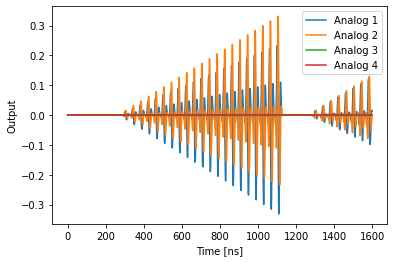

In [13]:
simulate = True

if simulate:
    simulation_config = SimulationConfig(duration=400)  # in clock cycles
    job_sim = qmm.simulate(config, hello_QUA, simulation_config)
    # Simulate blocks python until the simulation is done
    job_sim.get_simulated_samples().con1.plot()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(hello_QUA)
    # Execute does not block python! As this is an infinite loop, the job would run forever. In this case, we've put a 10
    # seconds sleep and then halted the job.
    time.sleep(10)
    job.halt()

# Mixer_Cal

In [14]:
with program() as cw_output:
    with infinite_loop_():
        # It is best to calibrate LO leakage first and without any power played (cf. note below)
        play("cw" * amp(0), "qubit")


2022-08-05 15:16:10,368 - qm - INFO - Flags: 
2022-08-05 15:16:10,368 - qm - INFO - Simulating program


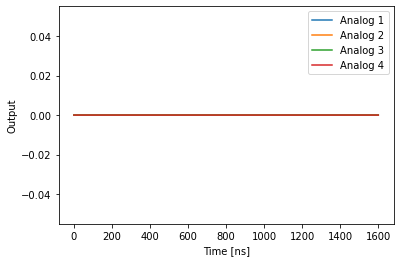

In [24]:
simulation_config = SimulationConfig(duration=400)
job_sim = qmm.simulate(config, cw_output, simulation_config)
job_sim.get_simulated_samples().con1.plot()

# Res_Spec_power

In [ ]:
n_avg = 100
cooldown_time = 10 * u.us // 4

p_max=20
p_min=-60
dp=1
f_min = 30e6
f_max = 70e6
df = 0.5e6
freqs = np.arange(f_min, f_max + 0.1, df) 
powers = np.arange(p_min, p_max+1, dp)
with program() as power_sweep:
    n = declare(int)
    f = declare(int)
    p = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()

    with for_(n, 0, n < n_avg, n + 1):
        with for_(p, 0, p<=p_max, p+dp):
            readout_amp=p
            with for_(f, f_min, f<=f_max, f+df):
                    update_frequency("resonator", f)
                    measure(
                    "long_readout",
                    "resonator",
                    None,
                    dual_demod.full("cos", "out1", "sin", "out2", I),
                    dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
                    )
                    wait(cooldown_time, "resonator")
                    save(I, I_st)
                    save(Q, Q_st)
    with stream_processing():
        I_st.buffer(len(freqs), len(powers)).average().save("I")
        Q_st.buffer(len(freqs), len(powers)).average().save("Q")


# Res_Spec

In [25]:
n_avg = 100

cooldown_time = 10 * u.us // 4

f_min = 30e6
f_max = 70e6
df = 0.5e6
freqs = np.arange(f_min, f_max + 0.1, df)  # + 0.1 to add f_max to freqs

with program() as resonator_spec:
    n = declare(int)
    f = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()

    with for_(n, 0, n < n_avg, n + 1):
        with for_(f, f_min, f <= f_max, f + df):  # Notice it's <= to include f_max (This is only for integers!)
            update_frequency("resonator", f)
            measure(
                "long_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            wait(cooldown_time, "resonator")
            save(I, I_st)
            save(Q, Q_st)

    with stream_processing():
        I_st.buffer(len(freqs)).average().save("I")
        Q_st.buffer(len(freqs)).average().save("Q")


2022-08-05 15:37:28,419 - qm - INFO - Flags: 
2022-08-05 15:37:28,419 - qm - INFO - Simulating program


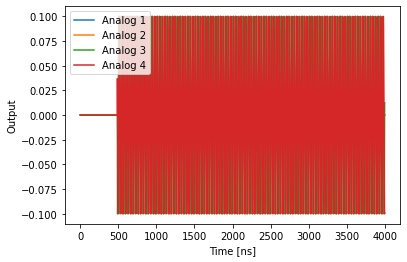

In [26]:
simulation_config = SimulationConfig(duration=1000)
job = qmm.simulate(config, resonator_spec, simulation_config)
job.get_simulated_samples().con1.plot()

2022-08-05 08:45:52,106 - qm - INFO - Flags: 
2022-08-05 08:45:52,106 - qm - INFO - Simulating program


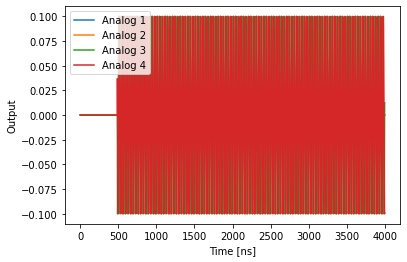

In [20]:
simulate = True

if simulate:
    simulation_config = SimulationConfig(duration=1000)
    job = qmm.simulate(config, resonator_spec, simulation_config)
    job.get_simulated_samples().con1.plot()

else:
    qm = qmm.open_qm(config)
    job = qm.execute(resonator_spec)

    # Get results from QUA program
    res_handles = job.result_handles
    I_handles = res_handles.get("I")
    Q_handles = res_handles.get("Q")
    I_handles.wait_for_values(1)
    Q_handles.wait_for_values(1)
    # Live plotting
    fig = plt.figure()
    interrupt_on_close(fig, job)  # Interrupts the job when closing the figure
    while job.result_handles.is_processing():
        # Fetch results
        I = res_handles.get("I").fetch_all()
        Q = res_handles.get("Q").fetch_all()
        # Plot results
        plt.subplot(211)
        plt.cla()
        plt.title("resonator spectroscopy amplitude")
        plt.plot(freqs / u.MHz, np.sqrt(I**2 + Q**2), ".")
        plt.xlabel("frequency [MHz]")
        plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [a.u.]")
        plt.subplot(212)
        plt.cla()
        # detrend removes the linear increase of phase
        phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
        plt.title("resonator spectroscopy phase")
        plt.plot(freqs / u.MHz, phase, ".")
        plt.xlabel("frequency [MHz]")
        plt.ylabel("Phase [rad]")
        plt.pause(0.1)
        plt.tight_layout()

    # Fetch results
    I = res_handles.get("I").fetch_all()
    Q = res_handles.get("Q").fetch_all()
    # Convert I & Q to Volts
    I = u.demod2volts(I, readout_len)
    Q = u.demod2volts(Q, readout_len)
    # 1D spectroscopy plot
    plt.clf()
    plt.subplot(211)
    plt.title("resonator spectroscopy amplitude [V]")
    plt.plot(freqs / u.MHz, np.sqrt(I**2 + Q**2), ".")
    plt.xlabel("frequency [MHz]")
    plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [a.u.]")
    plt.subplot(212)
    # detrend removes the linear increase of phase
    phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
    plt.title("resonator spectroscopy phase [rad]")
    plt.plot(freqs / u.MHz, phase, ".")
    plt.xlabel("frequency [MHz]")
    plt.ylabel("Phase [rad]")
    plt.tight_layout()

# qubit_spec

In [27]:
n_avg = 10000

cooldown_time = 5 * qubit_T1 // 4

f_min = 20e6
f_max = 100e6
df = 0.1e6
freqs = np.arange(f_min, f_max + 0.1, df)  # + 0.1 to add f_max to freqs

with program() as qubit_spec:
    n = declare(int)
    n_st = declare_stream()
    f = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()

    with for_(n, 0, n < n_avg, n + 1):
        with for_(f, f_min, f <= f_max, f + df):  # Notice it's <= to include f_max (This is only for integers!)
            update_frequency("qubit", f)
            play("saturation", "qubit")
            align("qubit", "resonator")
            measure(
                "readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time, "resonator")
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(freqs)).average().save("I")
        Q_st.buffer(len(freqs)).average().save("Q")
        n_st.save("iteration")

2022-08-05 15:39:49,700 - qm - INFO - Flags: 
2022-08-05 15:39:49,700 - qm - INFO - Simulating program


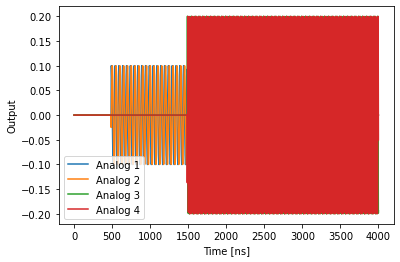

In [28]:
simulation_config = SimulationConfig(duration=1000)
job = qmm.simulate(config, qubit_spec, simulation_config)
job.get_simulated_samples().con1.plot()


# T1

In [10]:
tau_min = 4  # in clock cycles
tau_max = 100  # in clock cycles
dtau = 2  # in clock cycles
taus = np.arange(tau_min, tau_max + 0.1, dtau)  # + 0.1 to add t_max to taus

n_avg = 1e4
cooldown_time = 5 * qubit_T1 // 4

with program() as T1:
    n = declare(int)
    n_st = declare_stream()
    I = declare(fixed)
    I_st = declare_stream()
    Q = declare(fixed)
    Q_st = declare_stream()
    tau = declare(int)

    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(tau, taus)):
            play("pi", "qubit")
            wait(tau, "qubit")
            align("qubit", "resonator")
            measure(
                "readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time, "resonator")
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(taus)).average().save("I")
        Q_st.buffer(len(taus)).average().save("Q")
        n_st.save("iteration")

# where n?

2022-08-05 16:22:22,283 - qm - INFO - Flags: 
2022-08-05 16:22:22,283 - qm - INFO - Simulating program


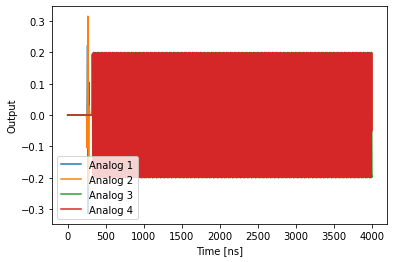

In [11]:
simulation_config = SimulationConfig(duration=1000)  # in clock cycles
job = qmm.simulate(config, T1, simulation_config)
job.get_simulated_samples().con1.plot()

# power_rabi

In [8]:
from qualang_tools.loops import from_array
n_avg = 10000

cooldown_time = 5 * qubit_T1 // 4

a_min = 0.0
a_max = 1.0
da = 0.05
amps = np.arange(a_min, a_max + da / 2, da)  # + da/2 to add a_max to amplitudes


with program() as power_rabi:
    n = declare(int)
    n_st = declare_stream()
    a = declare(fixed)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()

    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(a, amps)):
            play("gauss" * amp(a), "qubit", duration=x180_len // 4)
            align("qubit", "resonator")
            measure(
                "readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time, "resonator")
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(amps)).average().save("I")
        Q_st.buffer(len(amps)).average().save("Q")
        n_st.save("iteration")

2022-08-05 15:58:16,663 - qm - INFO - Flags: 
2022-08-05 15:58:16,663 - qm - INFO - Simulating program


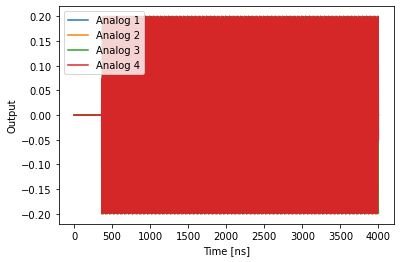

In [35]:
simulation_config = SimulationConfig(duration=1000)  # in clock cycles
job = qmm.simulate(config, power_rabi, simulation_config)
job.get_simulated_samples().con1.plot()

# IQ blob

In [36]:

n_runs = 10000

cooldown_time = 5 * qubit_T1 // 4

with program() as IQ_blobs:
    n = declare(int)
    I_g = declare(fixed)
    Q_g = declare(fixed)
    I_g_st = declare_stream()
    Q_g_st = declare_stream()
    I_e = declare(fixed)
    Q_e = declare(fixed)
    I_e_st = declare_stream()
    Q_e_st = declare_stream()

    with for_(n, 0, n < n_runs, n + 1):
        measure(
            "readout",
            "resonator",
            None,
            dual_demod.full("rotated_cos", "out1", "rotated_sin", "out2", I_g),
            dual_demod.full("rotated_minus_sin", "out1", "rotated_cos", "out2", Q_g),
        )
        save(I_g, I_g_st)
        save(Q_g, Q_g_st)
        wait(cooldown_time, "resonator")

        align()  # global align

        play("pi", "qubit")
        align("qubit", "resonator")
        measure(
            "readout",
            "resonator",
            None,
            dual_demod.full("rotated_cos", "out1", "rotated_sin", "out2", I_e),
            dual_demod.full("rotated_minus_sin", "out1", "rotated_cos", "out2", Q_e),
        )
        save(I_e, I_e_st)
        save(Q_e, Q_e_st)
        wait(cooldown_time, "resonator")

    with stream_processing():
        I_g_st.save_all("I_g")
        Q_g_st.save_all("Q_g")
        I_e_st.save_all("I_e")
        Q_e_st.save_all("Q_e")

2022-08-05 16:07:46,393 - qm - INFO - Flags: 
2022-08-05 16:07:46,393 - qm - INFO - Simulating program


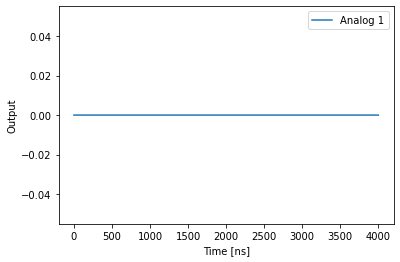

In [40]:
simulation_config = SimulationConfig(duration=1000)  # in clock cycles
job = qmm.simulate(config, IQ_blobs, simulation_config)
samples=job.get_simulated_samples()
analog1=samples.con1.analog['1']
samples.con1.plot(analog_ports=['1'])

# Ramsey

In [42]:
###################
# The QUA program #
###################

tau_min = 4  # in clock cycles
tau_max = 100  # in clock cycles
dtau = 2  # in clock cycles
taus = np.arange(tau_min, tau_max + 0.1, dtau)  # + 0.1 to add tau_max to taus

n_avg = 1e4
cooldown_time = 5 * qubit_T1 // 4

detuning = 1 * u.MHz  # in Hz

with program() as ramsey:
    n = declare(int)
    n_st = declare_stream()
    I = declare(fixed)
    I_st = declare_stream()
    Q = declare(fixed)
    Q_st = declare_stream()
    tau = declare(int)

    update_frequency("qubit", qubit_IF + detuning)

    with for_(n, 0, n < n_avg, n + 1):
        with for_(*from_array(tau, taus)):
            play("pi_half", "qubit")
            wait(tau, "qubit")
            play("pi_half", "qubit")
            align("qubit", "resonator")
            measure(
                "readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )
            save(I, I_st)
            save(Q, Q_st)
            wait(cooldown_time, "resonator")
        save(n, n_st)

    with stream_processing():
        I_st.buffer(len(taus)).average().save("I")
        Q_st.buffer(len(taus)).average().save("Q")
        n_st.save("iteration")
# why we dont used the variable n? Is it used in the stream_processing,average()?


2022-08-05 16:14:50,155 - qm - INFO - Flags: 
2022-08-05 16:14:50,155 - qm - INFO - Simulating program


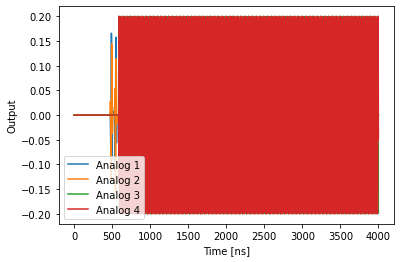

In [47]:
simulation_config = SimulationConfig(duration=1000)  # in clock cycles
job = qmm.simulate(config, ramsey, simulation_config)
job.get_simulated_samples().con1.plot()

# RB

In [6]:
from qm.qua import *
from qm.QuantumMachinesManager import QuantumMachinesManager
from scipy.optimize import curve_fit
#from configuration import *
import matplotlib.pyplot as plt
import numpy as np
from qualang_tools.bakery.randomized_benchmark_c1 import c1_table
from macros import readout_macros

inv_gates = [int(np.where(c1_table[i, :] == 0)[0][0]) for i in range(24)]
max_circuit_depth = int(3 * qubit_T1 / x180_len)
delta_depth = 1
num_of_sequences = 50
n_avg = 20
seed = 345324
cooldown_time = 5 * qubit_T1 // 4


ImportError: cannot import name 'readout_macros' from 'macros' (c:\Users\kimje\anaconda3\envs\quantummachines\lib\site-packages\macros\__init__.py)

In [50]:
def generate_sequence():
    cayley = declare(int, value=c1_table.flatten().tolist())
    inv_list = declare(int, value=inv_gates)
    current_state = declare(int)
    step = declare(int)
    sequence = declare(int, size=max_circuit_depth + 1)
    inv_gate = declare(int, size=max_circuit_depth + 1)
    i = declare(int)
    rand = Random(seed=seed)

    assign(current_state, 0)
    with for_(i, 0, i < max_circuit_depth, i + 1):
        assign(step, rand.rand_int(24))
        assign(current_state, cayley[current_state * 24 + step])
        assign(sequence[i], step)
        assign(inv_gate[i], inv_list[current_state])

    return sequence, inv_gate


def play_sequence(sequence_list, depth):
    i = declare(int)
    with for_(i, 0, i <= depth, i + 1):
        with switch_(sequence_list[i], unsafe=True):
            with case_(0):
                wait(x180_len // 4, "qubit")
            with case_(1):
                play("x180", "qubit")
            with case_(2):
                play("y180", "qubit")
            with case_(3):
                play("y180", "qubit")
                play("x180", "qubit")
            with case_(4):
                play("x90", "qubit")
                play("y90", "qubit")
            with case_(5):
                play("x90", "qubit")
                play("-y90", "qubit")
            with case_(6):
                play("-x90", "qubit")
                play("y90", "qubit")
            with case_(7):
                play("-x90", "qubit")
                play("-y90", "qubit")
            with case_(8):
                play("y90", "qubit")
                play("x90", "qubit")
            with case_(9):
                play("y90", "qubit")
                play("-x90", "qubit")
            with case_(10):
                play("-y90", "qubit")
                play("x90", "qubit")
            with case_(11):
                play("-y90", "qubit")
                play("-x90", "qubit")
            with case_(12):
                play("x90", "qubit")
            with case_(13):
                play("-x90", "qubit")
            with case_(14):
                play("y90", "qubit")
            with case_(15):
                play("-y90", "qubit")
            with case_(16):
                play("-x90", "qubit")
                play("y90", "qubit")
                play("x90", "qubit")
            with case_(17):
                play("-x90", "qubit")
                play("-y90", "qubit")
                play("x90", "qubit")
            with case_(18):
                play("x180", "qubit")
                play("y90", "qubit")
            with case_(19):
                play("x180", "qubit")
                play("-y90", "qubit")
            with case_(20):
                play("y180", "qubit")
                play("x90", "qubit")
            with case_(21):
                play("y180", "qubit")
                play("-x90", "qubit")
            with case_(22):
                play("x90", "qubit")
                play("y90", "qubit")
                play("x90", "qubit")
            with case_(23):
                play("-x90", "qubit")
                play("y90", "qubit")
                play("-x90", "qubit")


with program() as rb:
    depth = declare(int)
    saved_gate = declare(int)
    m = declare(int)
    n = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    state = declare(bool)
    state_st = declare_stream()

    with for_(m, 0, m < num_of_sequences, m + 1):
        sequence_list, inv_gate_list = generate_sequence()

        with for_(depth, 1, depth <= max_circuit_depth, depth + delta_depth):
            with for_(n, 0, n < n_avg, n + 1):
                # Replacing the last gate in the sequence with the sequence's inverse gate
                # The original gate is saved in 'saved_gate' and is being restored at the end
                assign(saved_gate, sequence_list[depth])
                assign(sequence_list[depth], inv_gate_list[depth - 1])

                # Can replace by active reset
                wait(cooldown_time, "resonator")

                align("resonator", "qubit")

                play_sequence(sequence_list, depth)
                align("qubit", "resonator")
                # Make sure you updated the ge_threshold
                state, I, Q = readout_macro(threshold=ge_threshold, state=state, I=I, Q=Q)

                save(state, state_st)

                assign(sequence_list[depth], saved_gate)

    with stream_processing():
        state_st.boolean_to_int().buffer(n_avg).map(FUNCTIONS.average()).buffer(
            num_of_sequences, max_circuit_depth
        ).save("res")


NameError: name 'readout_macro' is not defined